In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pydrake.solvers.mathematicalprogram import  Solve
from pydrake.systems.framework import InputPortSelection, OutputPortSelection, Context
 
from pydrake.examples.pendulum import (PendulumPlant, PendulumState)
from pydrake.all import (DirectCollocation, DirectTranscription, PiecewisePolynomial,
                                                 SolutionResult, TimeStep)
from pydrake.systems.primitives import FirstOrderTaylorApproximation
from pydrake.systems.controllers import LinearQuadraticRegulator

taylor: <pydrake.systems.primitives.AffineSystem_[float] object at 0x7f4af84bb670>
taylor.A: [[ 0.          1.        ]
 [19.61997512 -0.4       ]]
taylor.B: [[0.]
 [4.]]
context: ::_ Context
------------
Time: 0
States:
  2 continuous states
    [3.14, 0]

Parameters:
  1 numeric parameter groups with
     4 parameters
       [1, 0.5, 0.1, 9.81]

K: [[9.9108867  2.34242571]]
S: [[25.43404192  4.95544335]
 [ 4.95544335  1.17121286]]
sssssss
[Variable('x(38)', Continuous) Variable('x(39)', Continuous)]
[1.57079633 0.        ]
SNOPT/fortran
True
SolutionResult.kSolutionFound
0.0
4.424855352599014
0.0
4.424855352599014
(1, 100)
x
[0. 0.]
[1.57079633 0.        ]
u
-0.6298948197909633
0.40981877104084274


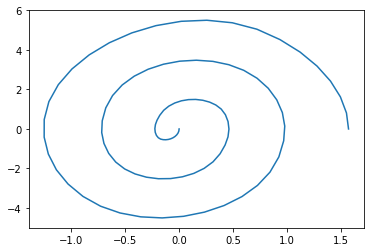

done


In [22]:
#from visualizer import PendulumVisualizer
Q = np.eye(2)*2
R = np.eye(1)*2
plant = PendulumPlant()
context = plant.CreateDefaultContext()
context.SetContinuousState(np.array([3.14, 0]))


# 
# plant.get_input_port(0).FixValue(context, 0)
#alternative way for fixing context
context.FixInputPort(index=0, data=[0.])

affine_sys = FirstOrderTaylorApproximation(plant, context)
K,S = LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(),Q, R)

print ('taylor:', affine_sys)
print ('taylor.A:', affine_sys.A())
print ('taylor.B:', affine_sys.B())
print ('context:', context)
print ('K:', K)
print ('S:', S)
# print ('S hsape', S.shape)

print("sssssss")
 
# dircol = DirectTranscription(plant, context, num_time_samples=50,
                        #     fixed_timestep=TimeStep(0.25))
dircol = DirectCollocation(plant, context, num_time_samples=20,
                            minimum_timestep=0.08, maximum_timestep=0.5)
 
#dircol.AddEqualTimeIntervalsConstraints()
 
torque_limit = 3.0  # N*m.
u = dircol.input()
dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)
 
initial_state = PendulumState()
initial_state.set_theta(0.0)
initial_state.set_thetadot(0.0)
dircol.AddBoundingBoxConstraint(initial_state.get_value(),
                            initial_state.get_value(),
                            dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state()
#                               == initial_state.get_value())
 
final_state = PendulumState()
final_state.set_theta(math.pi/2)
final_state.set_thetadot(0)

print(dircol.final_state())
dircol.AddBoundingBoxConstraint(final_state.get_value(),
                                final_state.get_value(),
                                dircol.final_state())

print(final_state.get_value())
# dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())
 
R = 10  # Cost on input "effort".
dircol.AddRunningCost(R*u[0]**2)
 
initial_x_trajectory = \
        PiecewisePolynomial.FirstOrderHold([0., 4.],
                                 [initial_state.get_value(),
                                 final_state.get_value()])
dircol.SetInitialTrajectory(PiecewisePolynomial(), 
                            initial_x_trajectory) 
# result = dircol.Solve()
result = Solve(dircol) 
print(result)
print(result.get_solver_id().name())
print(result.is_success())
print(result.get_solution_result())
assert(result.get_solution_result() == SolutionResult.kSolutionFound) 
# assert(result == SolutionResult.kSolutionFound) 
x_trajectory = dircol.ReconstructStateTrajectory(result) 
print(x_trajectory)
print(x_trajectory.start_time())
print(x_trajectory.end_time())

#construct u trajectory
u_trajectory = dircol.ReconstructInputTrajectory(result) 
print(u_trajectory)
print(u_trajectory.start_time())
print(u_trajectory.end_time())

#vis = PendulumVisualizer() 
#ani = vis.animate(x_trajectory, repeat=True) 
time_series=np.linspace(x_trajectory.start_time(),                                          
                      x_trajectory.end_time(), 100)
x_knots = np.hstack([x_trajectory.value(t) for t in                                          
                      time_series])
# x_knots = np.hstack([x_trajectory.value(t) for t in                                          
#                       np.linspace(x_trajectory.start_time(),                                          
#                       x_trajectory.end_time(), 100)]) 

cmds = np.hstack([u_trajectory.value(t) for t in                                          
                      np.linspace(u_trajectory.start_time(),                                          
                      u_trajectory.end_time(), 100)]) 
print(cmds.shape)
plt.figure() 
plt.plot(x_knots[0, :], x_knots[1, :]) 
print("x")
print(x_knots[:,0])
print(x_knots[:,-1])
print("u")
print(cmds[0,0])
print(cmds[0,-1])
plt.show() 
print('done')

## Below aree codes for bebop models


In [28]:
import numpy as np

from underactuated import PyPlotVisualizer
from pydrake.systems.framework import BasicVector_, LeafSystem_, PortDataType
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.systems.framework import (
    BasicVector, BasicVector_
)

In [18]:
# Note: In order to use the Python system with drake's autodiff features, we
# have to add a little "TemplateSystem" boilerplate (for now).  For details,
# see https://drake.mit.edu/pydrake/pydrake.systems.scalar_conversion.html

# TODO(russt): Clean this up pending any resolutions on
#  https://github.com/RobotLocomotion/drake/issues/10745

# todo: need to define each u and x 
@TemplateSystem.define("Quadrotor2D_")
def Quadrotor2D_(T):

    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # two inputs (thrust)
            self.DeclareVectorInputPort("u", BasicVector_[T](2))
            # six outputs (full state)
            self.DeclareVectorOutputPort("x", BasicVector_[T](4),
                                         self.CopyStateOut)
            # three positions, three velocities
            self.DeclareContinuousState(2, 2, 0)

            # parameters based on [Bouadi, Bouchoucha, Tadjine, 2007]
            #self.length = 0.25      # length of rotor arm
            self.mass = 0.42       # mass of quadrotor
            #self.inertia = 0.00383  # moment of inertia
            self.gravity = 9.81     # gravity

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CopyStateOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            y = output.SetFromVector(x)

        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            q = x[:2]
            qdot = x[2:]
            # all zeros?, the cos and sin below
            qddot = np.array([self.mass*self.gravity*np.cos(0)*np.tan(u[0])-
                              self.mass*self.gravity*np.sin(0)*np.tan(u[1]),
                              self.mass*self.gravity*np.sin(0)*np.tan(u[1])+
                              self.mass*self.gravity*np.cos(0)*np.tan(u[1])])
            derivatives.get_mutable_vector().SetFromVector(
                np.concatenate((qdot, qddot)))

    return Impl


bebop2d = Quadrotor2D_[None]  # Default instantiation


In [65]:
Q = np.eye(4)*2
R = np.eye(2)*2
plant = bebop2d()
plant

<pydrake.systems.scalar_conversion.Quadrotor2D_[float] at 0x7f4af6be4fa8>

In [66]:
context = plant.CreateDefaultContext()
context.SetContinuousState(np.array([0, 0, 0, 0]))
# plant.get_input_port(0).FixValue(context, 0)
context.FixInputPort(index=0, data=[0.,0.])

In [67]:
context = plant.CreateDefaultContext()
context.SetContinuousState(np.array([0, 0, 0, 0]))
# plant.get_input_port(0).FixValue(context, 0)
# context.FixInputPort(index=0, data=[0.,0.])#not sure if the data matters
context.FixInputPort(index=0, vec=BasicVector([0.,0.]))#more ways 

affine_sys = FirstOrderTaylorApproximation(plant, context)
K,S = LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(),Q, R)

print ('taylor:', affine_sys)
print ('taylor.A:', affine_sys.A())
print ('taylor.B:', affine_sys.B())
print ('context:', context)
print ('K:', K)
print ('S:', S)

taylor: <pydrake.systems.primitives.AffineSystem_[float] object at 0x7f4af6b7b270>
taylor.A: [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
taylor.B: [[0.     0.    ]
 [0.     0.    ]
 [4.1202 0.    ]
 [0.     4.1202]]
context: ::_ Context
------------
Time: 0
States:
  4 continuous states
    [0, 0, 0, 0]


K: [[1.         0.         1.21877534 0.        ]
 [0.         1.         0.         1.21877534]]
S: [[2.43755068 0.         0.48541333 0.        ]
 [0.         2.43755068 0.         0.48541333]
 [0.48541333 0.         0.5916098  0.        ]
 [0.         0.48541333 0.         0.5916098 ]]


## traj optimization with bebop model

<pydrake.systems.scalar_conversion.Quadrotor2D_[float] object at 0x7f4af6b5fd68>
taylor: <pydrake.systems.primitives.AffineSystem_[float] object at 0x7f4af6a83030>
taylor.A: [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
taylor.B: [[0.     0.    ]
 [0.     0.    ]
 [4.1202 0.    ]
 [0.     4.1202]]
context: ::_ Context
------------
Time: 0
States:
  4 continuous states
    [0, 0, 0, 0]


K: [[1.         0.         1.21877534 0.        ]
 [0.         1.         0.         1.21877534]]
S: [[2.43755068 0.         0.48541333 0.        ]
 [0.         2.43755068 0.         0.48541333]
 [0.48541333 0.         0.5916098  0.        ]
 [0.         0.48541333 0.         0.5916098 ]]
[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)]
[Variable('x(76)', Continuous) Variable('x(77)', Continuous)
 Variable('x(78)', Continuous) Variable('x(79)', Continuous)]
SNOPT/fortran
True
SolutionResult.kSolutionFound
0.0
2.64803424

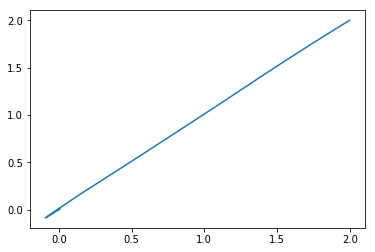

done


In [73]:
Q = np.eye(4)*2
R = np.eye(2)*2
plant = bebop2d()
print(plant)

context = plant.CreateDefaultContext()
context.SetContinuousState(np.array([0, 0, 0, 0]))
# plant.get_input_port(0).FixValue(context, 0)
# context.FixInputPort(index=0, data=[0.,0.])#not sure if the data matters
context.FixInputPort(index=0, vec=BasicVector([0.,0.]))#more ways 

affine_sys = FirstOrderTaylorApproximation(plant, context)
K,S = LinearQuadraticRegulator(affine_sys.A(), affine_sys.B(),Q, R)

print ('taylor:', affine_sys)
print ('taylor.A:', affine_sys.A())
print ('taylor.B:', affine_sys.B())
print ('context:', context)
print ('K:', K)
print ('S:', S)

dircol = DirectCollocation(plant, context, num_time_samples=20,
                            minimum_timestep=0.02, maximum_timestep=0.5)
 
#dircol.AddEqualTimeIntervalsConstraints()
 
input_limit = 30  # 
u = dircol.input()

dircol.AddConstraintToAllKnotPoints(u[0] <= input_limit)
dircol.AddConstraintToAllKnotPoints(u[0] >= -input_limit)
dircol.AddConstraintToAllKnotPoints(u[1] <= input_limit)
dircol.AddConstraintToAllKnotPoints(u[1] >= -input_limit)

start_pt=np.array([[0],[0],[0],[0]],dtype=np.float64)
end_pt=np.array([[2],[2],[0],[0]],dtype=np.float64)

dircol.AddBoundingBoxConstraint(start_pt,
                            start_pt,
                            dircol.initial_state())
dircol.AddBoundingBoxConstraint(end_pt,
                            end_pt,
                            dircol.final_state())

print(dircol.initial_state())
print(dircol.final_state())


R = 1  # Cost on input "effort".
# if constraints added, the problem is infeasible
# dircol.AddRunningCost(R*u[0]**2+R*u[1]**2)


# initial_x_trajectory = \
#         PiecewisePolynomial.FirstOrderHold([0., 4.],
#                                  [initial_state.get_value(),
#                                  final_state.get_value()])

initial_u = PiecewisePolynomial.ZeroOrderHold([0, 1],
                                            np.zeros((1, 2)))
initial_x = PiecewisePolynomial()
    
dircol.SetInitialTrajectory(traj_init_u=initial_u,
                            traj_init_x=initial_x) 

result = Solve(dircol) 
print(result)
print(result.get_solver_id().name())
print(result.is_success())
print(result.get_solution_result())
assert(result.get_solution_result() == SolutionResult.kSolutionFound) 
# assert(result == SolutionResult.kSolutionFound) 
x_trajectory = dircol.ReconstructStateTrajectory(result) 
print(x_trajectory)
print(x_trajectory.start_time())
print(x_trajectory.end_time())

#construct u trajectory
u_trajectory = dircol.ReconstructInputTrajectory(result) 
print(u_trajectory)
print(u_trajectory.start_time())
print(u_trajectory.end_time())

#vis = PendulumVisualizer() 
#ani = vis.animate(x_trajectory, repeat=True) 
time_series=np.linspace(x_trajectory.start_time(),                                          
                      x_trajectory.end_time(), 100)
x_knots = np.hstack([x_trajectory.value(t) for t in                                          
                      time_series])
# x_knots = np.hstack([x_trajectory.value(t) for t in                                          
#                       np.linspace(x_trajectory.start_time(),                                          
#                       x_trajectory.end_time(), 100)]) 

cmds = np.hstack([u_trajectory.value(t) for t in                                          
                      np.linspace(u_trajectory.start_time(),                                          
                      u_trajectory.end_time(), 100)]) 
print(cmds.shape)
plt.figure() 
plt.plot(x_knots[0, :], x_knots[1, :]) 
print("x")
print(x_knots[:,0])
print(x_knots[:,-1])
print("u")
print(cmds[0,0])
print(cmds[0,-1])
plt.show() 
print('done')

## sometimes this runs, sometimes it doesn't give a result
## ignore what's below

In [37]:
ini_sta=dircol.initial_state()
ini_sta.item

<function ndarray.item>

In [ ]:

R = 10  # Cost on input "effort".
dircol.AddRunningCost(R*u[0]**2)
 
initial_x_trajectory = \
        PiecewisePolynomial.FirstOrderHold([0., 4.],
                                 [initial_state.get_value(),
                                 final_state.get_value()])
dircol.SetInitialTrajectory(PiecewisePolynomial(), 
                            initial_x_trajectory) 
# result = dircol.Solve()
result = Solve(dircol) 
print(result)
print(result.get_solver_id().name())
print(result.is_success())
print(result.get_solution_result())
assert(result.get_solution_result() == SolutionResult.kSolutionFound) 
# assert(result == SolutionResult.kSolutionFound) 
x_trajectory = dircol.ReconstructStateTrajectory(result) 
print(x_trajectory)
print(x_trajectory.start_time())
print(x_trajectory.end_time())

#construct u trajectory
u_trajectory = dircol.ReconstructInputTrajectory(result) 
print(u_trajectory)
print(u_trajectory.start_time())
print(u_trajectory.end_time())

#vis = PendulumVisualizer() 
#ani = vis.animate(x_trajectory, repeat=True) 
time_series=np.linspace(x_trajectory.start_time(),                                          
                      x_trajectory.end_time(), 100)
x_knots = np.hstack([x_trajectory.value(t) for t in                                          
                      time_series])
# x_knots = np.hstack([x_trajectory.value(t) for t in                                          
#                       np.linspace(x_trajectory.start_time(),                                          
#                       x_trajectory.end_time(), 100)]) 

cmds = np.hstack([u_trajectory.value(t) for t in                                          
                      np.linspace(u_trajectory.start_time(),                                          
                      u_trajectory.end_time(), 100)]) 
print(cmds.shape)
plt.figure() 
plt.plot(x_knots[0, :], x_knots[1, :]) 
print("x")
print(x_knots[:,0])
print(x_knots[:,-1])
print("u")
print(cmds[0,0])
print(cmds[0,-1])
plt.show() 
print('done')